In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from matplotlib import backend_bases
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
backend_bases.register_backend("pdf", FigureCanvasPgf)

plt.style.use("acmcompat.mplstyle")

pd.options.mode.copy_on_write = True


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks?


## RQ6: Is model similarity enough to detect poisoning attacks?


### Test methodology

```yaml
partitioner: glob(iid_*)
+datasets: nfv2/sampled/cicids
batch_size: 512
+epochs: 100/10x10
+distribution: 10-0,9-1,5-5
+target: dos,ddos,bot,bruteforce,infiltration,untargeted
+scenario: continuous-100
seed: 1138,421,1313,5555,6567,327,2187,1977,501,3263827
```

- goal is to evaluate the impact of dataset partitioning on the similarity of models, and therefore the ability to detect poisoning attacks in such a context
- hyperparameters are fixed as the "best" ones from RQ2
- $\alpha=100$
- 3 benign-attackers distributions
  - 0% attacker to see the impact of the partitioning performance
  - 10% attackers (ie, one client) to see if his model is identifiable
  - 50% attackers to see if similar attacks are detectable
- all attacks to see if there are differences + untargeted

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("similarity/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"5-5, 9-1, 10-0"
epochs,100_10x10
scenario,continuous-100
target,"untargeted, infiltration, dos, bruteforce, ddos, bot"
batch_size,512
partitioner,"iid_drop_1, kmeans_drop_1, iid_drop_2, kmeans_drop_2, iid_keep_1, iid_full, kmeans_full, kmeans_keep_1"
seed,"1138, 421, 5555, 2187, 1313, 327, 6567, 501, 3263827, 1977"


### Partitioning effect on data distribution

- make a dataframe with the the sample numbers in each partitioning scheme
  - columns are the partitioning schemes
  - rows are tuples "{partition}-{label}"

In [4]:
import json
import re
from pathlib import Path

import pandas as pd
from eiffel.analysis.metrics import search_results

SEED = 1138

paths = search_results(
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
    distribution="10-0",
    seed=SEED,
)

part_re = r"partitioner=(\w+),"

stats_df = pd.DataFrame()

for path in paths:
    res = re.search(part_re, path)
    assert res is not None
    partitioner = res.group(1)

    idx = []
    samples = []

    stats = next(iter(json.loads((Path(path) / "stats.json").read_text()).values()))
    for k, v in stats.items():
        part = "_".join(k.split("_")[1:])
        train_stats: dict = v.get("train")
        assert train_stats is not None

        for label in [
            "Benign",
            "Bot",
            "DDoS",
            "DoS",
            "Brute Force",
            "Infilteration",
            "injection",
        ]:
            idx.append(f"{part}_{label}")
            n = train_stats.get(label)
            if n is None:
                n = 0
            samples.append(n)

        s = pd.Series(samples, index=idx, name=partitioner).astype(int)

    stats_df = pd.concat([stats_df, s], axis=1)

stats_df

,iid_drop_1,iid_drop_2,iid_full,iid_keep_1,kmeans_drop_1,kmeans_drop_2,kmeans_full,kmeans_keep_1
benign_0_Benign,70432,70432,70432,70432,38441,38441,38441,38441
benign_0_Bot,616,616,616,0,616,616,616,0
benign_0_DDoS,5887,0,5887,0,5887,0,5887,0
benign_0_DoS,0,0,2051,2051,0,0,2051,2051
benign_0_Brute Force,522,522,522,0,522,522,522,0
...,...,...,...,...,...,...,...,...
benign_9_DDoS,5886,5886,5886,0,5886,5886,5886,0
benign_9_DoS,2051,0,2051,0,2051,0,2051,0
benign_9_Brute Force,0,0,522,522,0,0,522,522
benign_9_Infilteration,492,492,492,0,492,492,492,0


### Impact on the benign scenario

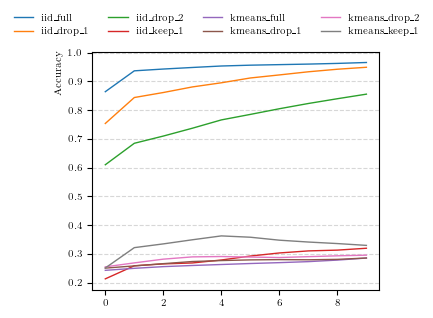

In [5]:
from functools import partial

from eiffel.analysis.metrics import load_df, search_results

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
    distribution="10-0",
)

fig, ax = plt.subplots(
    1, 1, figsize=figsize(1, 0.8), constrained_layout=True, sharex=True, sharey=True
)

for i, partitioning in enumerate(
    [
        "iid_full",
        "iid_drop_1",
        "iid_drop_2",
        "iid_keep_1",
        "kmeans_full",
        "kmeans_drop_1",
        "kmeans_drop_2",
        "kmeans_keep_1",
    ]
):
    data = load_df(searchfn(partitioner=partitioning), dotpath="global.f1", attr="fit")

    ax.plot(data.mean(axis=0), label=partitioning)


ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_ylabel("Accuracy", loc="top")

lgd = fig.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.15))

fig.savefig(
    SAVEDIR + "hyperparams-accdiff.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

In [6]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import search_results
from sklearn.decomposition import PCA

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
    distribution="10-0",
)

grads_df = pd.DataFrame()
seed_re = r"seed=(\d+)(?:,.*)?"

for partitioner in [
    "iid_full",
    "iid_drop_1",
    "iid_drop_2",
    "iid_keep_1",
    "kmeans_full",
    "kmeans_drop_1",
    "kmeans_drop_2",
    "kmeans_keep_1",
]:
    for path in searchfn(partitioner=partitioner):
        res = re.search(seed_re, path)
        assert res is not None
        seed = res.group(1)
        part_grads_dfs: list[pd.DataFrame] = [
            pd.read_pickle(p) for p in Path(path).glob("grads*.pkl")
        ]
        part_grads_df = pd.concat(part_grads_dfs, axis=0)
        part_grads_df["Partitioner"] = partitioner
        part_grads_df["Seed"] = seed
        grads_df = pd.concat([grads_df, part_grads_df], axis=0, ignore_index=True)

grads_array = np.array(grads_df["Gradients"].tolist())
pca = PCA(n_components=2)
grads_pca = pca.fit_transform(grads_array)

grads_df["PCA1"] = grads_pca[:, 0]
grads_df["PCA2"] = grads_pca[:, 1]

grads_df["Client"] = grads_df["Client"].apply(lambda x: "_".join(x.split("_")[1:]))

Text(0.5, 0.98, 'Gradients in 2D, colored by client')

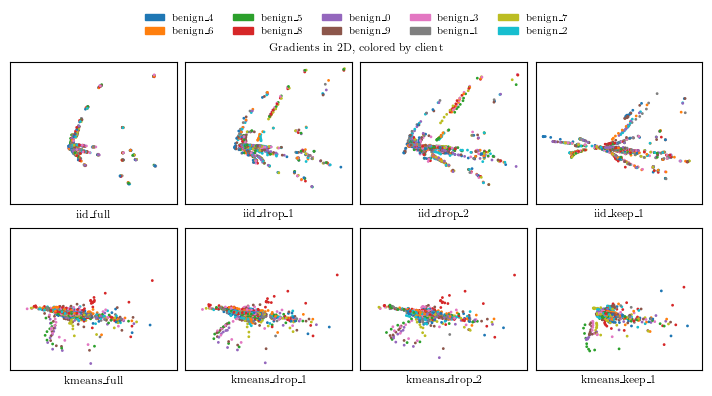

In [7]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

df = grads_df  # [grads_df["Seed"] == "1138"]

levels, categories = pd.factorize(df["Client"])
df["Color"] = [plt.cm.tab10(i) for i in levels]
handles = [Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[df["Partitioner"] == partitioner]

    ax.scatter(data["PCA1"], data["PCA2"], s=1, c=data["Color"])


lgd = fig.legend(handles=handles, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.1))
fig.suptitle("Gradients in 2D, colored by client")

Text(0.5, 0.98, 'Gradients in 2D, colored by client')

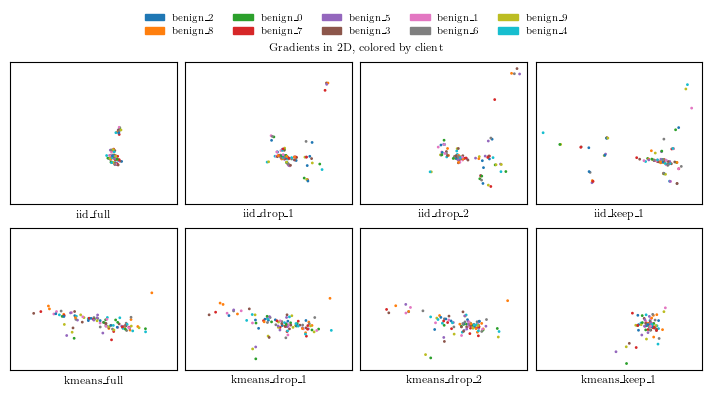

In [8]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

df = grads_df[grads_df["Round"] == 10]

levels, categories = pd.factorize(df["Client"])
df["Color"] = [plt.cm.tab10(i) for i in levels]
handles = [Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[df["Partitioner"] == partitioner]

    ax.scatter(data["PCA1"], data["PCA2"], s=1, c=data["Color"])


lgd = fig.legend(handles=handles, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.1))
fig.suptitle("Gradients in 2D, colored by client")

Text(0.5, 0.98, 'Gradients in 2D, colored by round')

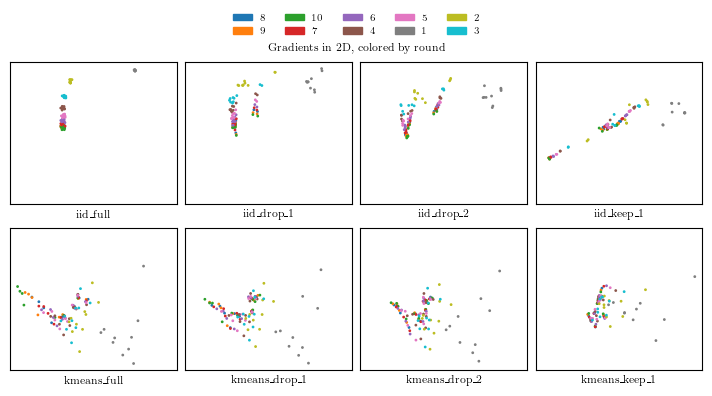

In [9]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

df = grads_df[grads_df["Seed"] == "1138"]

levels, categories = pd.factorize(df["Round"])
df["Color"] = [plt.cm.tab10(i) for i in levels]
handles = [Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[df["Partitioner"] == partitioner]

    ax.scatter(data["PCA1"], data["PCA2"], s=1, c=data["Color"])


lgd = fig.legend(handles=handles, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.1))
fig.suptitle("Gradients in 2D, colored by round")

### Identifiability of one lone attacker

In [3]:
import itertools
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import search_results
from sklearn.decomposition import PCA

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    datasets=".*cicids",
    distribution="9-1",
)

grads_df = pd.DataFrame()

for target, partitioner in itertools.product(
    [
        "untargeted",
        "dos",
        "ddos",
        "bot",
        "bruteforce",
        "infiltration",
        "injection",
    ],
    [
        "iid_full",
        "iid_drop_1",
        "iid_drop_2",
        "iid_keep_1",
        "kmeans_full",
        "kmeans_drop_1",
        "kmeans_drop_2",
        "kmeans_keep_1",
    ],
):
    print(target, partitioner)
    for path in searchfn(partitioner=partitioner):
        part_grads_dfs: list[pd.DataFrame] = [
            pd.read_pickle(p) for p in Path(path).glob("grads*.pkl")
        ]
        part_grads_df = pd.concat(part_grads_dfs, axis=0, ignore_index=True)
        part_grads_df["Partitioner"] = partitioner
        part_grads_df["Target"] = target
        grads_df = pd.concat([grads_df, part_grads_df], axis=0, ignore_index=True)

print("done loading")

grads_array = np.array(grads_df["Gradients"].tolist())
pca = PCA(n_components=2)
grads_pca = pca.fit_transform(grads_array)

grads_df["PCA1"] = grads_pca[:, 0]
grads_df["PCA2"] = grads_pca[:, 1]

grads_df["Client"] = grads_df["Client"].apply(lambda x: "_".join(x.split("_")[1:]))

untargeted iid_full
untargeted iid_drop_1
untargeted iid_drop_2
untargeted iid_keep_1
untargeted kmeans_full
untargeted kmeans_drop_1
untargeted kmeans_drop_2
untargeted kmeans_keep_1
dos iid_full
dos iid_drop_1
dos iid_drop_2
dos iid_keep_1
dos kmeans_full
dos kmeans_drop_1
dos kmeans_drop_2
dos kmeans_keep_1
ddos iid_full
ddos iid_drop_1
ddos iid_drop_2
ddos iid_keep_1
ddos kmeans_full
ddos kmeans_drop_1
ddos kmeans_drop_2
ddos kmeans_keep_1
bot iid_full
bot iid_drop_1
bot iid_drop_2
bot iid_keep_1
bot kmeans_full
bot kmeans_drop_1
bot kmeans_drop_2
bot kmeans_keep_1
bruteforce iid_full
bruteforce iid_drop_1
bruteforce iid_drop_2
bruteforce iid_keep_1
bruteforce kmeans_full
bruteforce kmeans_drop_1
bruteforce kmeans_drop_2
bruteforce kmeans_keep_1
infiltration iid_full
infiltration iid_drop_1
infiltration iid_drop_2
infiltration iid_keep_1
infiltration kmeans_full
infiltration kmeans_drop_1
infiltration kmeans_drop_2


: 

Text(0.5, 0.98, 'Gradients in 2D, colored by round')

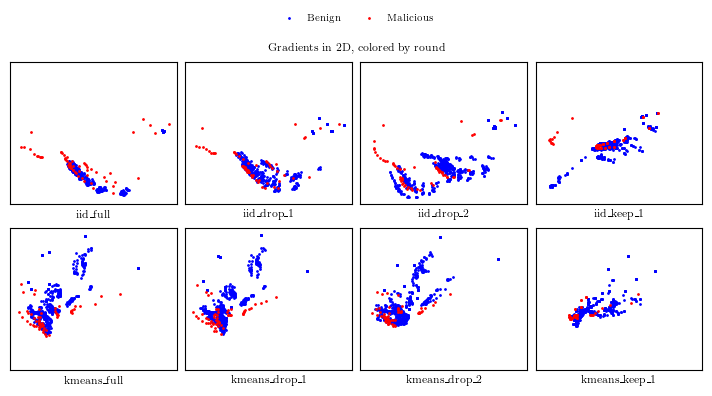

In [5]:
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator

df = grads_df

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[(df["Partitioner"] == partitioner) & (df["Target"] == "untargeted")]

    # grads_array = np.array(grads_df["Gradients"].tolist())
    # pca = PCA(n_components=2)
    # grads_pca = pca.fit_transform(grads_array)

    # data["PCA1"] = grads_pca[:, 0]
    # data["PCA2"] = grads_pca[:, 1]

    benign = data[data["Client"].str.contains("benign")]
    ax.scatter(benign["PCA1"], benign["PCA2"], s=1, c="blue", label="Benign")

    malicious = data[data["Client"].str.contains("malicious")]
    ax.scatter(malicious["PCA1"], malicious["PCA2"], s=1, c="red", label="Malicious")

handles, labels = axs.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles=handles,
    labels=labels,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
)
fig.suptitle("Gradients in 2D, colored by round")

/var/folders/6v/8wy9dm6938n6yt0_hkf53crr0000gn/T/ipykernel_19658/432576434.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Color"] = [plt.cm.tab10(i) for i in levels]


Text(0.5, 0.98, 'Gradients in 2D, colored by round')

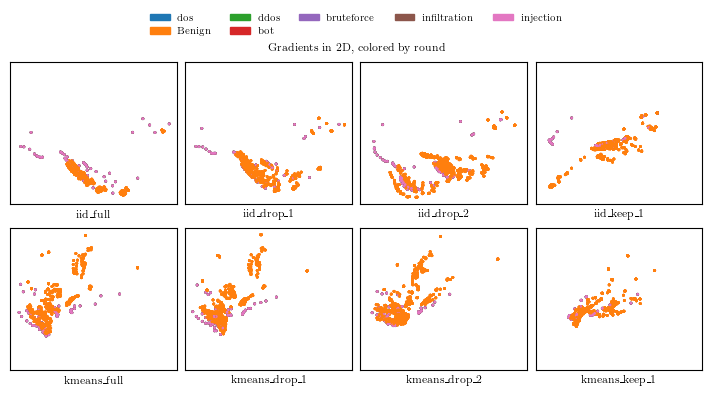

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

df = grads_df[grads_df["Target"] != "untargeted"]

levels, categories = pd.factorize(
    df.apply(
        lambda row: "Benign" if "benign" in row["Client"] else row["Target"], axis=0
    )
)
df["Color"] = [plt.cm.tab10(i) for i in levels]
handles = [Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[df["Partitioner"] == partitioner]

    ax.scatter(data["PCA1"], data["PCA2"], s=1, c=data["Color"])

lgd = fig.legend(handles=handles, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.1))
fig.suptitle("Gradients in 2D, colored by round")

### Detectability of similar attacks